In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

data_dir = "/DigestPath2019/task2_classification/tissue-train-pos-v1"

# 이미지를 1/4 크기로 로드
scale_percent = 25  # 원본의 25%
image = cv2.imread(os.path.join(data_dir, "D20181010201_2019-05-21 14_08_09-lv1-57001-816-15224-14673.jpg"))
mask = cv2.imread(os.path.join(data_dir, "D20181010201_2019-05-21 14_08_09-lv1-57001-816-15224-14673_mask.jpg"))

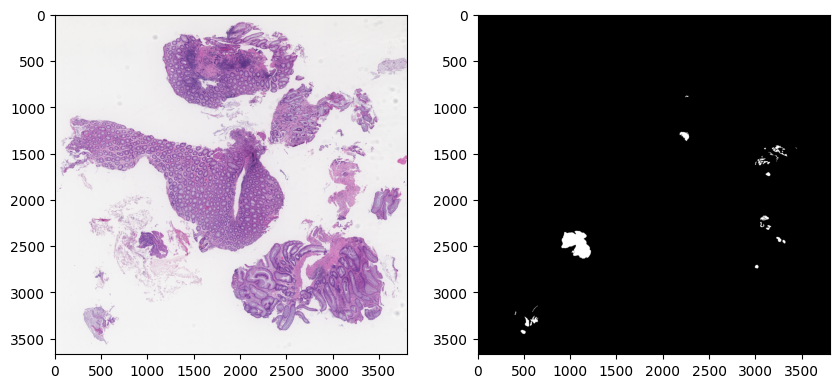

In [2]:
# 이미지 크기 조정
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
image_resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
mask_resized = cv2.resize(mask, dim, interpolation=cv2.INTER_AREA)

# OpenCV는 BGR 형식으로 로드하므로 RGB로 변환

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
mask_rgb = cv2.cvtColor(mask_resized, cv2.COLOR_BGR2RGB)

# 이미지 표시
axes[0].imshow(image_rgb)
axes[1].imshow(mask_rgb)
plt.show()


In [3]:
import mlflow
from tableone import TableOne

from camelyon.log_ops import TRACKING_URI

mlflow.set_tracking_uri(TRACKING_URI)

data = mlflow.search_runs(
    experiment_names=["attention_induction"], 
    filter_string=("params.dataset = 'digest'")
)
data_view = data[["metrics.test_auroc", "metrics.test_prauc", "metrics.test_accuracy", "params.learning"]]

# Rename
learning_strategy_map = {
    "base": "Base(AB-MIL)", 
    "attention_induction": "Attention Induction", 
    "ltr": "Rank Induction"
}
data_view['params.learning'] = data_view['params.learning'].replace(learning_strategy_map)
df_melted = data_view.melt(id_vars=["params.learning"], var_name="metric", value_name="value")


print(TableOne(data_view, 
    groupby="params.learning", 
    columns=["metrics.test_auroc", "metrics.test_prauc", "metrics.test_accuracy"], 
    decimals=4, 
    missing=False, 
    overall=False
))


                                  Grouped by params.learning                                  
                                         Attention Induction     Base(AB-MIL)   Rank Induction
n                                                         10               10               10
metrics.test_auroc, mean (SD)                0.9935 (0.0025)  0.9928 (0.0029)  0.9951 (0.0018)
metrics.test_prauc, mean (SD)                0.9900 (0.0038)  0.9895 (0.0046)  0.9932 (0.0023)
metrics.test_accuracy, mean (SD)             0.9652 (0.0120)  0.9636 (0.0171)  0.9674 (0.0134)



/tmp/ipykernel_969737/767540210.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_view['params.learning'] = data_view['params.learning'].replace(learning_strategy_map)


/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)



AUROC - Base(AB-MIL) vs Rank Induction Mann-Whitney U statistic: 25.5000 p-value: 0.0347

AUROC - Attention Induction vs Rank Induction Mann-Whitney U statistic: 29.0000 p-value: 0.0600

AUPRC - Base(AB-MIL) vs Rank Induction Mann-Whitney U statistic: 26.0000 p-value: 0.0378

AUPRC - Attention Induction vs Rank Induction Mann-Whitney U statistic: 24.0000 p-value: 0.0270

Accuracy - Base(AB-MIL) vs Rank Induction Mann-Whitney U statistic: 44.0000 p-value: 0.3363

Accuracy - Attention Induction vs Rank Induction Mann-Whitney U statistic: 44.0000 p-value: 0.3352


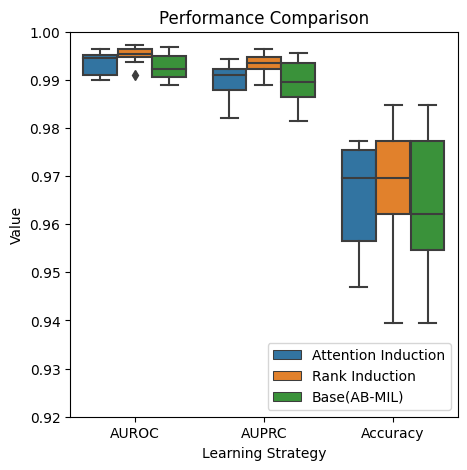

In [6]:
import seaborn as sns
df_melted["metric"] = df_melted["metric"].str.replace("metrics.", "", regex=False)
df_melted["metric"] = df_melted["metric"].replace({
    "test_auroc": "AUROC", 
    "test_prauc": "AUPRC", 
    "test_accuracy": "Accuracy"
})
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.boxplot(data=df_melted, x="metric", y="value", hue="params.learning", ax=ax)
ax.set_xlabel("Learning Strategy")
ax.set_ylabel("Value")
ax.legend(loc="lower right")
ax.set_ylim(0.92, 1.00)

# 필요하다면 타이틀 추가 가능
plt.title("Performance Comparison")

box_pairs = [
    # AUROC
    (("AUROC", "Base(AB-MIL)"), ("AUROC", "Rank Induction")),
    (("AUROC", "Attention Induction"), ("AUROC", "Rank Induction")),
    
    # AUPRC
    (("AUPRC", "Base(AB-MIL)"), ("AUPRC", "Rank Induction")),
    (("AUPRC", "Attention Induction"), ("AUPRC", "Rank Induction")),
    
    # Accuracy
    (("Accuracy", "Base(AB-MIL)"), ("Accuracy", "Rank Induction")),
    (("Accuracy", "Attention Induction"), ("Accuracy", "Rank Induction")),
]
from scipy import stats

for pair in box_pairs:
    metric, (method1, method2) = pair[0][0], (pair[0][1], pair[1][1])
    
    # 각 방법의 데이터 추출
    data1 = df_melted[(df_melted['metric'] == metric) & (df_melted['params.learning'] == method1)]['value']
    data2 = df_melted[(df_melted['metric'] == metric) & (df_melted['params.learning'] == method2)]['value']
    
    # Mann-Whitney U 검정 수행 (alternative='less'는 data1이 data2보다 작은지 검정)
    statistic, pvalue = stats.mannwhitneyu(data1, data2, alternative='less')
    
    print(f"\n{metric} - {method1} vs {method2}", f"Mann-Whitney U statistic: {statistic:.4f}", f"p-value: {pvalue:.4f}")